<a href="https://colab.research.google.com/github/FaridRash/IGNIS/blob/main/Notebooks/ML/ML_SNR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
in this notebook i will calculate the SNR of the target and background on wavelength range 8-14
"""

'\nin this notebook i will calculate the SNR of the target and background on wavelength range 8-14\n'

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeaturesfrom sklearn.metrics


In [ ]:
c1 = 3.7418e8
c2 = 1.4388e4
h = 6.626e-34
c = 3e8

In [ ]:
def compute_gsd(H, f, p):
  return (H * p / f) **2

In [ ]:
epsilon = 0.95
tau_0 = 0.89
eta = 0.7
t = 0.01
focal_length = 72.8 / 1000
pixel = 12e-6
F_number = 1.05
D = (focal_length / F_number)

lambda_range = np.arange(8, 14, 0.1)
delta_lambda = 0.1

In [ ]:
def compute_wighted_snr(Tg,Tf, theta_deg, R, tau_a):
  # The area of the target and background
    Af = 10*10
    Agsd = compute_gsd(R, focal_length, pixel)
    Ag = Agsd - Af

    #Blackbody calculation
    cos_theta = np.cos(np.deg2rad(theta_deg))
    M_lambda_g = c1 / (lambda_range**5 * (np.exp(c2 / (lambda_range * Tg)) - 1))
    M_lambda_f = c1 / (lambda_range**5 * (np.exp(c2 / (lambda_range * Tf)) - 1))

    #Radiance calculation
    E_lambda_g = epsilon * M_lambda_g
    E_lambda_f = epsilon * M_lambda_f

    #Signal calculation
    S_lambda_g = ((D**2 * t * cos_theta * Ag) / (4 * R**2 * h * c)) * (lambda_range * E_lambda_g * tau_a * tau_0 * eta * delta_lambda)
    S_lambda_f = ((D**2 * t * cos_theta * Af) / (4 * R**2 * h * c)) * (lambda_range * E_lambda_f * tau_a * tau_0 * eta * delta_lambda)


    #Sum of S
    S_Ag = np.sum(S_lambda_g)
    S_Af = np.sum(S_lambda_f)

    #S' calculation
    S_prime_g = S_Ag / Ag
    S_prime_f = S_Af / Af
    S_prime = S_prime_f - S_prime_g

    #N' calculation
    N_prime = np.sqrt(S_prime_f + S_prime_g)

    #SNR' calculation
    SNR_prime = S_prime / N_prime


    #Spectral SNR Contribution per λ
    #S'_lambda calculation
    S_prime_lambda_g = S_lambda_g / Ag
    S_prime_lambda_f = S_lambda_f / Af

    #S'_lambda calculation
    S_prime_lambda = S_prime_lambda_f - S_prime_lambda_g

    #SNR'_lambda
    SNR_prime_lambda = S_prime_lambda / N_prime

    return SNR_prime, SNR_prime_lambda, S_prime, N_prime





In [ ]:
Tf_range = np.arange(413.15, 434.15, 5)
Tg_range = np.arange(283.15, 374.15, 10)
R_range = np.arange(460000, 149999, -20665)
tau_a = np.arange(0.1, 0.6, .05)
theta_range = np.arange(0, 22, 2)
print(len(Tf_range) * len(Tg_range) * len(R_range) * len(tau_a) * len(theta_range))

88000


In [ ]:
df = pd.DataFrame(columns=['Tg', 'Tf', 'theta', 'R', 'tau_a'])

In [ ]:
data = []
for Tg in Tg_range:
    for R in R_range:
        for tau in tau_a:
            for theta in theta_range:
                for Tf in Tf_range:
                  # Compute weighted SNR
                  snr, snr_lambda, s_prime, n_prime = compute_wighted_snr(Tg, Tf, theta, R, tau)

                 # Append all features + result to the dataset
                  data.append({
                     'Tg': Tg,
                     'Tf': Tf,
                     'theta': theta,
                     'R': R,
                     'tau_a': tau,
                     "SNR'": snr,
                     "SNR_lambda": snr_lambda,
                     "S'": s_prime,
                     "N'": n_prime
                  })
df = pd.DataFrame(data)

In [ ]:
df.columns

Index(['Tg', 'Tf', 'theta', 'R', 'tau_a', 'SNR'', 'SNR_lambda', 'S'', 'N''], dtype='object')

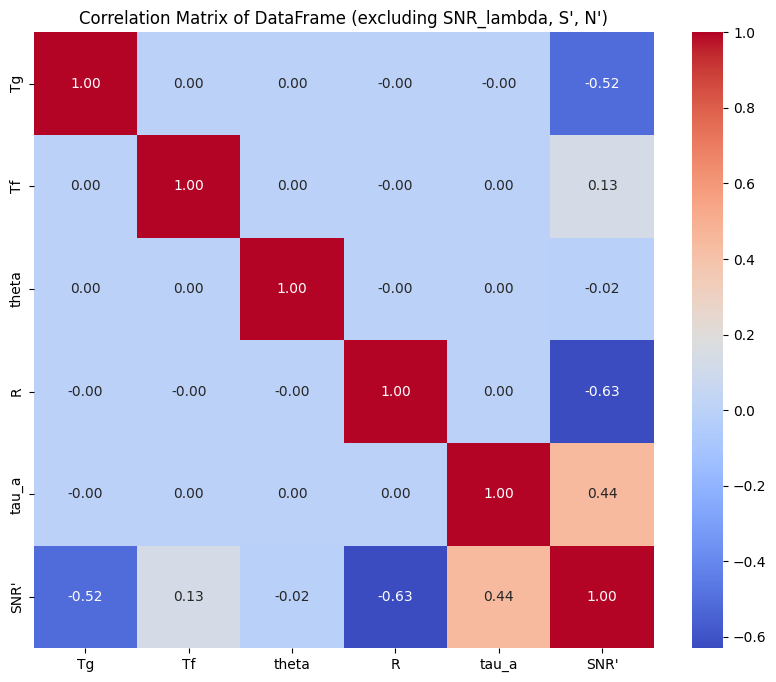

In [ ]:
# Drop the specified columns
df_corr = df.drop(columns=["SNR_lambda", "S'", "N'"])

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of DataFrame (excluding SNR_lambda, S\', N\')')
plt.show()

In [ ]:
X = ['Tg', 'Tf', 'theta', 'R', 'tau_a']
y = "SNR'"

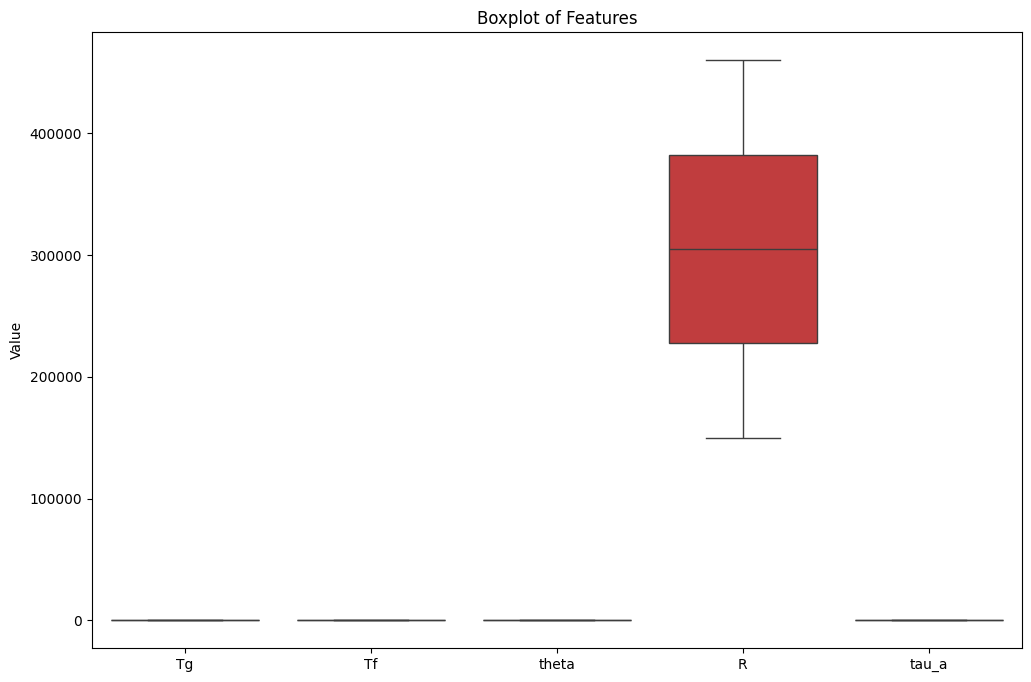

In [ ]:
# prompt: plot X features with boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[X])
plt.title('Boxplot of Features')
plt.ylabel('Value')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.2, random_state=42)

In [ ]:
len(X_test), len(X_train), len(y_test), len(y_train)

(17600, 70400, 17600, 70400)

Scaled Training Data:
         Tg        Tf     theta         R     tau_a
0  0.174820  1.414400  0.005804  0.759521 -1.217025
1 -1.216784 -1.412693 -0.943645  0.542590 -1.217025
2  0.870622  1.414400 -0.943645  0.542590  0.522422
3 -0.520982  0.707627  0.005804 -0.975928 -1.564915
4  1.566424  0.000853  0.638770 -1.626721  1.218201

Scaled Test Data:
         Tg        Tf     theta         R     tau_a
0 -1.216784 -1.412693 -1.576611  0.325658 -0.173357
1 -1.564685 -1.412693  1.271735 -0.108204  1.566091
2  0.870622 -1.412693 -0.627162  0.325658  0.870312
3 -0.520982  0.000853 -1.576611 -0.325135 -0.521246
4 -0.520982  1.414400  0.322287 -0.325135  0.522422


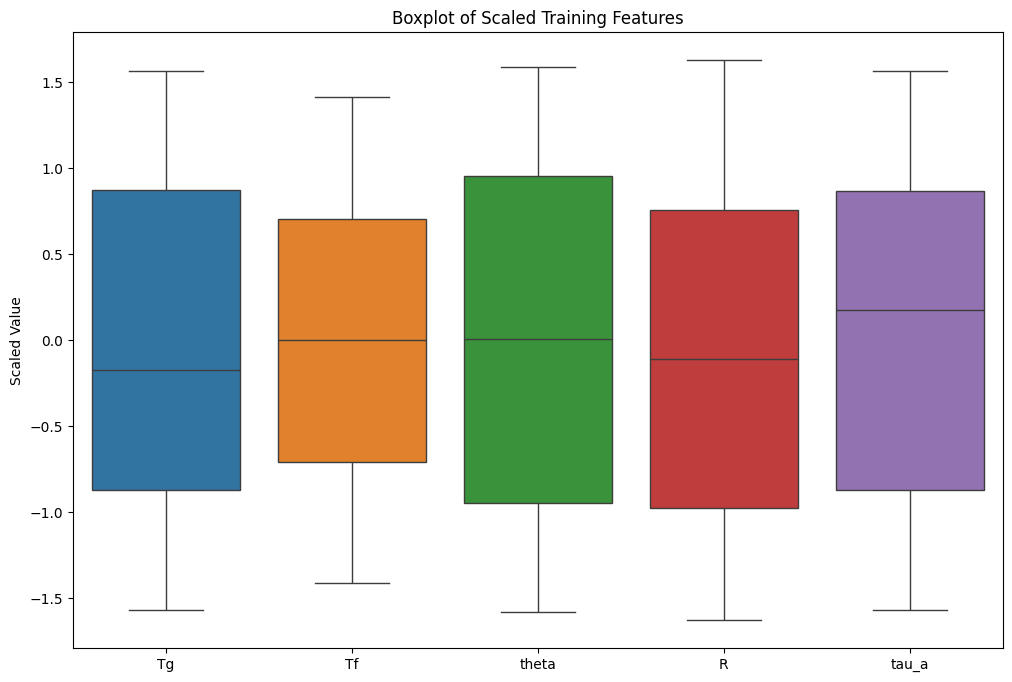

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames (optional, but often useful)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Display the first few rows of the scaled dataframes to verify
print("Scaled Training Data:")
print(X_train_scaled_df.head())

print("\nScaled Test Data:")
print(X_test_scaled_df.head())

# You can also visualize the scaled data to see the effect
plt.figure(figsize=(12, 8))
sns.boxplot(data=X_train_scaled_df)
plt.title('Boxplot of Scaled Training Features')
plt.ylabel('Scaled Value')
plt.show()

Mean Squared Error: 9927668516.30
R-squared: 0.88

Model Coefficients:
Tg: -146480.2413
Tf: 37625.8905
theta: -5178.1184
R: -178921.0238
tau_a: 125933.9562
Intercept: 525200.6656


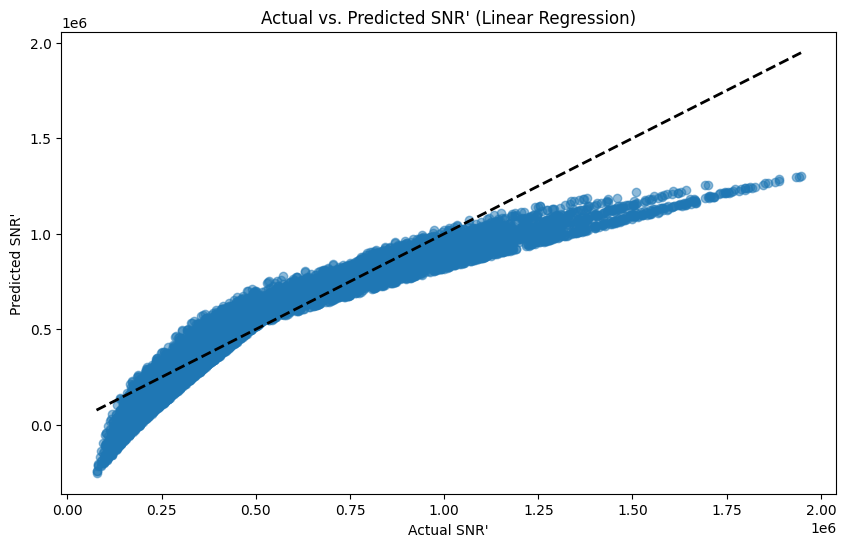

In [ ]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Display model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual SNR'")
plt.ylabel("Predicted SNR'")
plt.title("Actual vs. Predicted SNR' (Linear Regression)")
plt.show()

In [ ]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # You can tune n_estimators

In [ ]:
# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

In [ ]:
# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest R-squared: {r2_rf:.2f}")

Random Forest Mean Squared Error: 6054958.21
Random Forest R-squared: 1.00


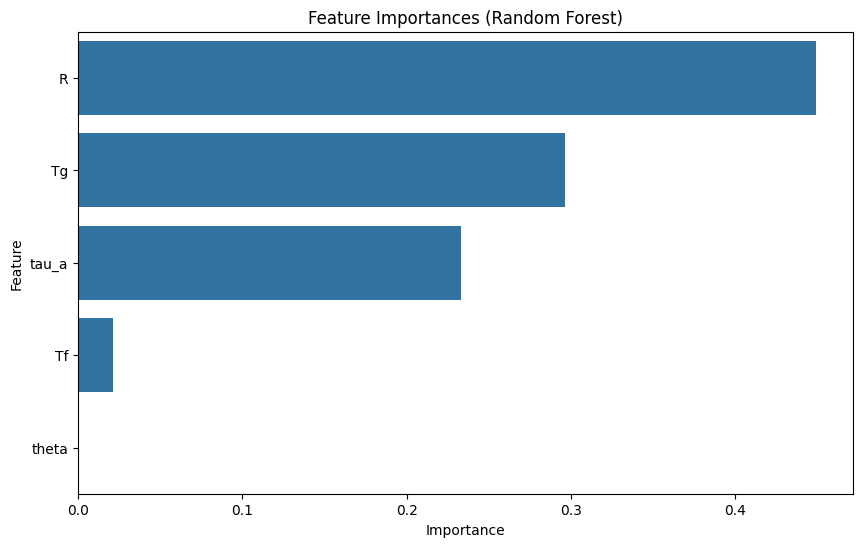

In [ ]:
# Get feature importances
feature_importances = rf_model.feature_importances_
features = X_train.columns
# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances (Random Forest)')
plt.show()

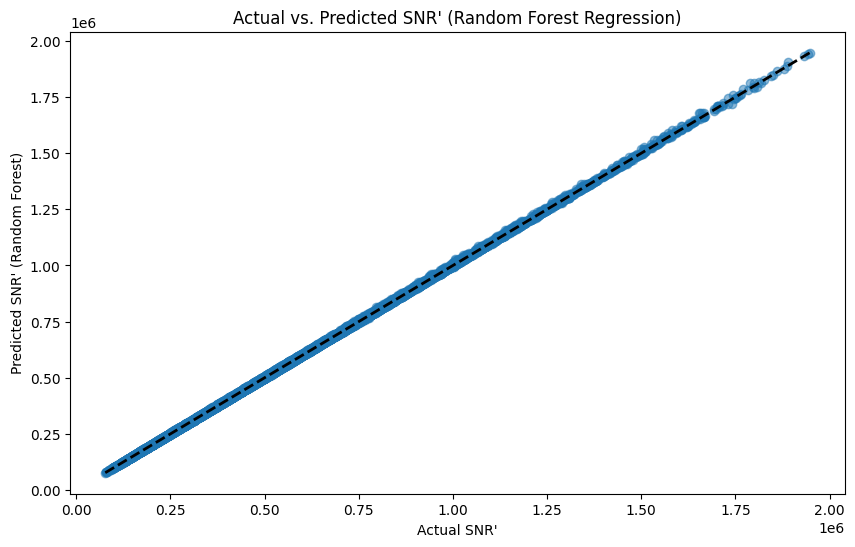

In [ ]:
# Plot actual vs predicted values for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual SNR'")
plt.ylabel("Predicted SNR' (Random Forest)")
plt.title("Actual vs. Predicted SNR' (Random Forest Regression)")
plt.show()

In [ ]:
# Perform cross-validation
# cv=5 means 5-fold cross-validation
# scoring='neg_mean_squared_error' is commonly used for regression;
# we take the negative because cross_val_score maximizes the score
cv_scores_mse = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive MSE for interpretability
cv_mse_scores = -cv_scores_mse

# You can also use R-squared as a scoring metric
cv_scores_r2 = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"Cross-validated MSE scores: {cv_mse_scores}")
print(f"Mean Cross-validated MSE: {cv_mse_scores.mean():.2f}")
print(f"Standard Deviation of Cross-validated MSE: {cv_mse_scores.std():.2f}")

print(f"\nCross-validated R2 scores: {cv_scores_r2}")
print(f"Mean Cross-validated R2: {cv_scores_r2.mean():.2f}")
print(f"Standard Deviation of Cross-validated R2: {cv_scores_r2.std():.2f}")


Cross-validated MSE scores: [ 9359309.09129072  9012244.91351277  8804623.48682661  9801110.13000254
 10132538.83168185]
Mean Cross-validated MSE: 9421965.29
Standard Deviation of Cross-validated MSE: 490218.94

Cross-validated R2 scores: [0.99988573 0.99988816 0.99989077 0.99987811 0.99987274]
Mean Cross-validated R2: 1.00
Standard Deviation of Cross-validated R2: 0.00


SVR (RBF Kernel) Mean Squared Error: 14364945521.74
SVR (RBF Kernel) R-squared: 0.82


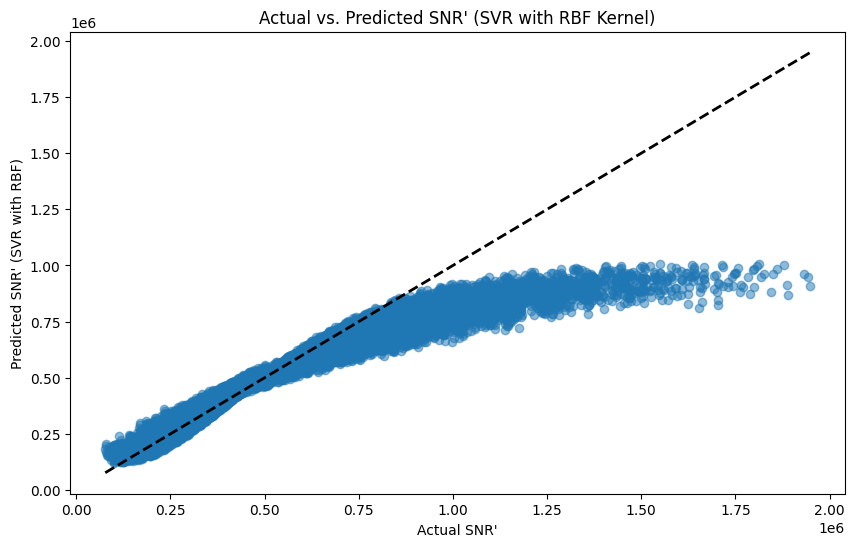

In [ ]:
# Initialize the SVR model with RBF kernel
# C is the regularization parameter, gamma defines the influence of a single training example
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1) # Hyperparameters can be tuned

# Train the model
svr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR (RBF Kernel) Mean Squared Error: {mse_svr:.2f}")
print(f"SVR (RBF Kernel) R-squared: {r2_svr:.2f}")

# Plot actual vs predicted values for SVR
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual SNR'")
plt.ylabel("Predicted SNR' (SVR with RBF)")
plt.title("Actual vs. Predicted SNR' (SVR with RBF Kernel)")
plt.show()

# Perform cross-validation for SVR
cv_scores_mse_svr = cross_val_score(svr_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores_svr = -cv_scores_mse_svr

cv_scores_r2_svr = cross_val_score(svr_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"\nSVR (RBF Kernel) Cross-validated MSE scores: {cv_mse_scores_svr}")
print(f"SVR (RBF Kernel) Mean Cross-validated MSE: {cv_mse_scores_svr.mean():.2f}")
print(f"SVR (RBF Kernel) Standard Deviation of Cross-validated MSE: {cv_mse_scores_svr.std():.2f}")

print(f"\nSVR (RBF Kernel) Cross-validated R2 scores: {cv_scores_r2_svr}")
print(f"SVR (RBF Kernel) Mean Cross-validated R2: {cv_scores_r2_svr.mean():.2f}")
print(f"SVR (RBF Kernel) Standard Deviation of Cross-validated R2: {cv_scores_r2_svr.std():.2f}")


In [ ]:
# Create polynomial features. Let's start with degree 2.
degree = 2
poly_features = PolynomialFeatures(degree=degree, include_bias=False)

# Create a pipeline that first transforms features to polynomial and then applies Linear Regression
poly_reg_model = make_pipeline(poly_features, LinearRegression())

# Train the polynomial regression model on the scaled data
# The pipeline handles the feature transformation internally
poly_reg_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_poly = poly_reg_model.predict(X_test_scaled)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"\nPolynomial Regression (Degree {degree}) Mean Squared Error: {mse_poly:.2f}")
print(f"Polynomial Regression (Degree {degree}) R-squared: {r2_poly:.2f}")

# Plot actual vs predicted values for Polynomial Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual SNR'")
plt.ylabel(f"Predicted SNR' (Polynomial Regression Degree {degree})")
plt.title(f"Actual vs. Predicted SNR' (Polynomial Regression Degree {degree})")
plt.show()


In [ ]:
# Perform cross-validation for Polynomial Regression
cv_scores_mse_poly = cross_val_score(poly_reg_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores_poly = -cv_scores_mse_poly

cv_scores_r2_poly = cross_val_score(poly_reg_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"\nPolynomial Regression (Degree {degree}) Cross-validated MSE scores: {cv_mse_scores_poly}")
print(f"Polynomial Regression (Degree {degree}) Mean Cross-validated MSE: {cv_mse_scores_poly.mean():.2f}")
print(f"Polynomial Regression (Degree {degree}) Standard Deviation of Cross-validated MSE: {cv_mse_scores_poly.std():.2f}")

print(f"\nPolynomial Regression (Degree {degree}) Cross-validated R2 scores: {cv_scores_r2_poly}")
print(f"Polynomial Regression (Degree {degree}) Mean Cross-validated R2: {cv_scores_r2_poly.mean():.2f}")
print(f"Polynomial Regression (Degree {degree}) Standard Deviation of Cross-validated R2: {cv_scores_r2_poly.std():.2f}")